In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}, nrows=250000000)
X = np.array(data['acoustic_data']).reshape((-1, 1000))
y = np.array(data['time_to_failure'])[::1000]
print(X.shape, y.shape)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

(250000, 1000) (250000,)
cuda


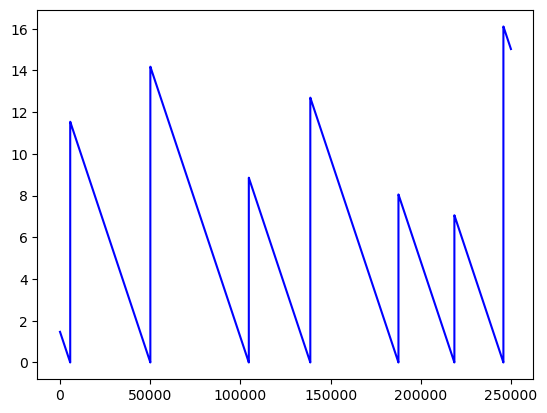

In [3]:
#plt.plot(list(range(len(X_train))), X_train.numpy(), c="r")
plt.plot(list(range(len(y))), y, c="b")
plt.show()

In [4]:
X_train = torch.tensor(X[:200000], dtype=torch.float32).to(device)
X_val = torch.tensor(X[200000:], dtype=torch.float32).to(device)
y_train = torch.tensor(y[:200000], dtype=torch.float32).to(device)
y_val = torch.tensor(y[200000:], dtype=torch.float32).to(device)

In [5]:
class RNNModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, layer_dim=1, output_dim=1, dropout_prob=0.5):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        for p in self.rnn.parameters():
            nn.init.normal_(p, mean=0.0, std=0.001)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden_prev):
        '''print(x.dtype, hidden_prev.dtype)
        for p in self.rnn.parameters():
            print(p.dtype)'''
        out, hidden_prev = self.rnn(x, hidden_prev)        
        out = self.fc(out)
        return out, hidden_prev


In [6]:
model = RNNModel(input_dim=X_train.shape[1])
#test model input and output
o, h = model(torch.randn((1, 1000)), torch.randn((1, 16)))
print(o)
print(h.shape)
model.to(device)

d:\ProgramData\Anaconda3\envs\mydl\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


tensor([[0.0062]], grad_fn=<AddmmBackward0>)
torch.Size([1, 16])


RNNModel(
  (rnn): RNN(1000, 16, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [7]:
hidden_size = 16
lr = 0.01
print_iter = 2000
train_losses = []

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)
hidden_prev = torch.zeros((1, hidden_size), dtype=torch.float32).to(device)

for i in range(len(X_train)):
    loss_sum = 0.0
    x_training = X_train[i].reshape((1, -1))
    output, hidden_prev = model(x_training, hidden_prev)
    hidden_prev = hidden_prev.detach()
    loss = criterion(output, y_train[i].reshape((1,-1)))
    loss_sum += loss.item()
    model.zero_grad()
    loss.backward()
    optimizer.step()

    if i % print_iter == 0:
        print("Iteration: {} loss {}".format(i, loss_sum / print_iter))
        train_losses.append(loss_sum / print_iter)
        loss_sum = 0.0
        


Iteration: 0 loss 0.000983452022075653
Iteration: 2000 loss 5.420477577899874e-11
Iteration: 4000 loss 2.2871549845149273e-09
Iteration: 6000 loss 3.38681729772361e-10
Iteration: 8000 loss 2.998349373228848e-10
Iteration: 10000 loss 3.364402800798416e-11
Iteration: 12000 loss 7.719063432887197e-11
Iteration: 14000 loss 8.263232302851975e-10
Iteration: 16000 loss 6.024497452017385e-10
Iteration: 18000 loss 8.601000445196405e-09
Iteration: 20000 loss 1.9532562873791905e-09
Iteration: 22000 loss 1.0869516700040549e-08
Iteration: 24000 loss 5.7471083891869055e-09
Iteration: 26000 loss 2.5818837912083836e-10
Iteration: 28000 loss 1.9932040231651625e-08
Iteration: 30000 loss 4.140463715884834e-08
Iteration: 32000 loss 5.538868208532222e-11
Iteration: 34000 loss 3.1694071367383e-11
Iteration: 36000 loss 2.3053144104778767e-10
Iteration: 38000 loss 2.7463585183795658e-11


KeyboardInterrupt: 

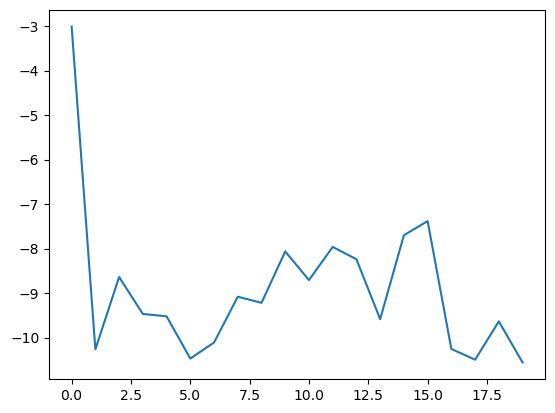

In [9]:
plt.plot(np.log10(train_losses))
plt.show()

In [12]:
yhat = []
with torch.no_grad():
    train_hidden_prev = torch.zeros((1, hidden_size), dtype=torch.float32).to(device)
    model.eval()
    for i in range(50000):
        x_t = X_train[i].reshape((1, -1))
        output, train_hidden_prev = model(x_t, train_hidden_prev)
        yhat.append(output.cpu().numpy()[0][0])
        if i % 5000 == 0:
            print(i)
print(len(yhat))

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000


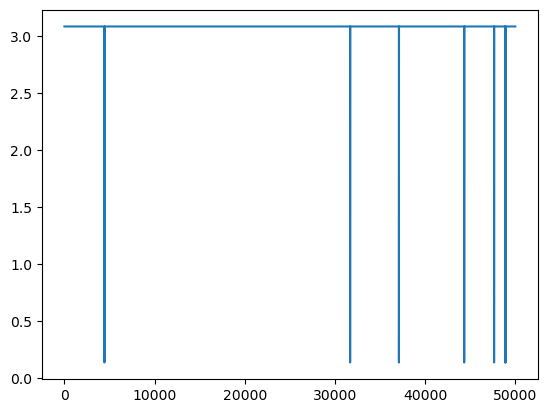

In [13]:
plt.plot(yhat)
plt.show()

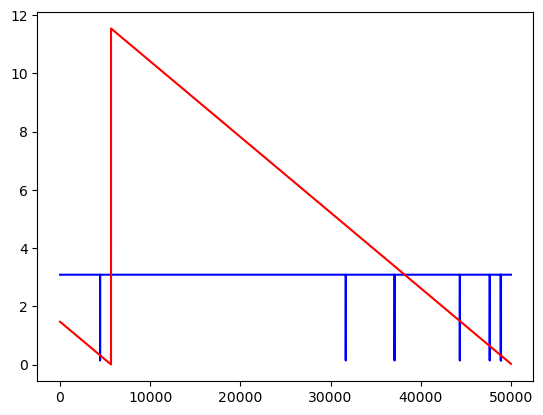

In [14]:
plt.plot(yhat, c="b")
plt.plot(y[:50000], c="r")
plt.show()

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, layer_dim=1, output_dim=1, dropout_prob=0.5):
        super(LSTMModel, self).__init__()
        self.rnn = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        for p in self.rnn.parameters():
            nn.init.normal_(p, mean=0.0, std=0.001)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden_prev):
        '''print(x.dtype, hidden_prev.dtype)
        for p in self.rnn.parameters():
            print(p.dtype)'''
        out, hidden_prev = self.rnn(x, hidden_prev)        
        out = self.fc(out)
        return out, hidden_prev

In [21]:
lstm_model = LSTMModel(input_dim=X_train.shape[1])
#test model input and output
o, (h, c) = lstm_model(torch.randn((1, 1000)), (torch.randn((1, 16)), torch.randn((1, 16))))
print(o)
print(h.shape, c.shape)
lstm_model.to(device)

tensor([[-0.1552]], grad_fn=<AddmmBackward0>)
torch.Size([1, 16]) torch.Size([1, 16])


LSTMModel(
  (rnn): LSTM(1000, 16, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [22]:
hidden_size = 16
lr = 0.01
print_iter = 2000
train_losses = []

criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr)
hhh = torch.zeros((1, hidden_size), dtype=torch.float32).to(device)
ccc = torch.zeros((1, hidden_size), dtype=torch.float32).to(device)

for i in range(len(X_train)):
    loss_sum = 0.0
    x_training = X_train[i].reshape((1, -1))
    output, (hhh, ccc) = lstm_model(x_training, (hhh, ccc))
    hhh = hhh.detach()
    ccc = ccc.detach()
    loss = criterion(output, y_train[i].reshape((1,-1)))
    loss_sum += loss.item()
    lstm_model.zero_grad()
    loss.backward()
    optimizer.step()

    if i % print_iter == 0:
        print("Iteration: {} loss {}".format(i, loss_sum / print_iter))
        train_losses.append(loss_sum / print_iter)
        loss_sum = 0.0
        

Iteration: 0 loss 0.0010023423433303833
Iteration: 2000 loss 1.1266595834058535e-10
Iteration: 4000 loss 9.195848349463631e-11
Iteration: 6000 loss 8.189836080418899e-10
Iteration: 8000 loss 5.09027813677676e-10
Iteration: 10000 loss 2.0719426174764521e-10
Iteration: 12000 loss 2.2282620193436743e-14
Iteration: 14000 loss 2.9103830456733705e-12
Iteration: 16000 loss 1.583580014994368e-07
Iteration: 18000 loss 1.279051648452878e-07
Iteration: 20000 loss 1.3137935184204252e-10
Iteration: 22000 loss 9.727330052555772e-11
Iteration: 24000 loss 1.1277916200924664e-10
Iteration: 26000 loss 7.890498636697884e-09
Iteration: 28000 loss 3.441191438469105e-08
Iteration: 30000 loss 9.35243633648497e-11
Iteration: 32000 loss 2.1413598005892708e-11
Iteration: 34000 loss 1.8077582808473381e-10
Iteration: 36000 loss 1.7229060176759958e-08


KeyboardInterrupt: 

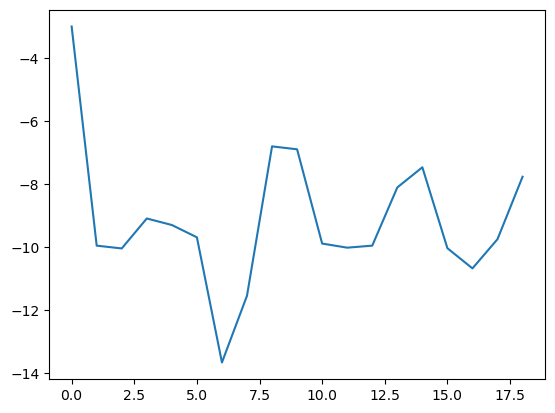

In [23]:
plt.plot(np.log10(train_losses))
plt.show()

In [24]:
yhat = []
with torch.no_grad():
    hhh = torch.zeros((1, hidden_size), dtype=torch.float32).to(device)
    ccc = torch.zeros((1, hidden_size), dtype=torch.float32).to(device)
    lstm_model.eval()
    for i in range(100000):
        x_t = X_train[i].reshape((1, -1))
        output, (hhh, ccc) = lstm_model(x_t, (hhh, ccc))
        yhat.append(output.cpu().numpy()[0][0])
        if i % 5000 == 0:
            print(i)
print(len(yhat))

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000


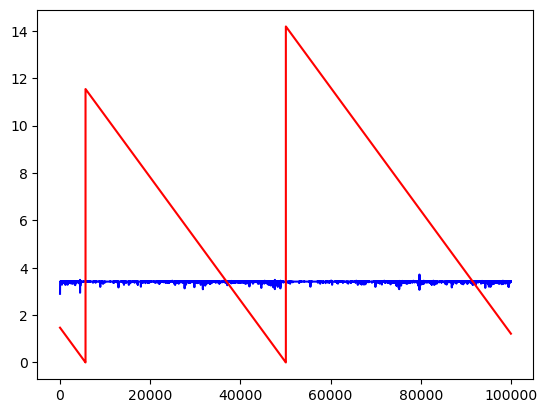

In [25]:
plt.plot(yhat, c="b")
plt.plot(y[:100000], c="r")
plt.show()